# Global Data Loading Test

测试全球数据统一接口

测试内容：
1. 加载全球 abandonment 数据 (.nc + .csv)
2. 加载全球 feature 数据
3. 加载 PV embedding 数据
4. 加载全球矢量边界
5. 验证数据对齐

## Update loading

In [4]:

import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / "src"))

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import yaml
%load_ext autoreload
%autoreload 2
print("✅ Import successful")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Import successful


## 1. Load Configuration

In [6]:
from landuse.data import GlobalDataPaths, get_global_paths

# Load config
config_path = Path.cwd().parent / "configs" / "global.yaml"
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Initialize paths
paths = GlobalDataPaths(config, workspace_root=Path.cwd().parent)

print("📂 Global Data Paths Initialized")
print(f"   Workspace: {paths.workspace_root}")
print(f"   Total paths: {len(paths.list_all_paths())}")

📂 Global Data Paths Initialized
   Workspace: c:\Dev\Landuse_Global_Pipeline_Worktree
   Total paths: 27


## 2. Inspect All Configured Paths

In [3]:
# Display all paths
all_paths = paths.list_all_paths()

print("\n📋 All Configured Paths:\n")
for key, value in all_paths.items():
    if isinstance(value, dict):
        print(f"  {key}:")
        for k, v in value.items():
            print(f"    - {k}: {v}")
    else:
        print(f"  {key}: {value}")


📋 All Configured Paths:

  abandonment_nc: D:/xarray/merged_chunk_2/*.nc
  abandonment_csv: D:/xarray/03_test/Global_total_2020.csv
  feature: D:/xarray/aligned2/Feature_all/*.nc
  emission: D:/xarray/aligned2/Emission_all/*.nc
  pv_sites_csv: C:/Dev/Landuse_Zhong_clean/data/aligned_for_training0519.csv
  pv_embedding: C:/Dev/Landuse_Zhong_clean/data/training_embedding.csv
  world_shp: C:/Dev/Landuse_Zhong_clean/data/main_ADM_0.shp
  cn_sheng: data/sheng2022.shp
  us_county: data/cb_2018_us_county_5m.shp
  test_output: positive_samples_test_500.csv
  full_output: positive_samples_full_with_features.csv
  carbon_benefit: data/4.data_prediction_net_benefit.csv
  restoration_strategies: data/4.1 Restoration_strategy_data.csv
  weighted_density: data/4.df_strategies.csv
  pv_npv_base: data/5.1_photovoltaic_results_demand_scenario_5.csv
  pv_npv_scenarios:
    - electrification: data/5.1_photovoltaic_results_demand_scenario_0.csv
    - high_growth: data/5.1_photovoltaic_results_demand_scen

## 3. Test: Load Abandonment Data (NetCDF)

In [7]:
from landuse.data import load_all_ds

print("🔄 Loading abandonment + feature datasets...")
print(f"   Abandonment: {paths.get('abandonment_nc')}")
print(f"   Features: {paths.get('feature')}")

# Load merged dataset
try:
    ds = load_all_ds(paths, chunks={'lat': 500, 'lon': 500, 'time': 1})
    
    print("\n✅ Dataset loaded successfully!")
    print(f"\n📊 Dataset Info:")
    print(f"   Dimensions: {dict(ds.dims)}")
    print(f"   Variables: {list(ds.data_vars)}")
    print(f"   Coordinates: {list(ds.coords)}")
    print(f"   Spatial extent: Lon [{float(ds.lon.min()):.2f}, {float(ds.lon.max()):.2f}], Lat [{float(ds.lat.min()):.2f}, {float(ds.lat.max()):.2f}]")
    
except Exception as e:
    print(f"\n❌ Error loading dataset: {e}")
    ds = None

🔄 Loading abandonment + feature datasets...
   Abandonment: D:/xarray/merged_chunk_2/*.nc
   Features: D:/xarray/aligned2/Feature_all/*.nc


c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\_task_spec.py:763: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\_task_spec.py:763: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\_task_spec.py:763: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\_task_spec.py:763: UserWarning: The specifi


✅ Dataset loaded successfully!

📊 Dataset Info:
   Dimensions: {'time': 31, 'lat': 21600, 'lon': 43200}
   Variables: ['abandonment_year', 'abandonment_duration', 'recultivation', 'current_abandonment', 'landcover', 'DEM', 'GDPpc', 'GDPtot', 'GURdist', 'Population', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'Slope', 'TertiaryRoad', 'gdmp', 'landcover_at_abandonment', 'rsds', 'tas', 'wind']
   Coordinates: ['time', 'spatial_ref', 'band', 'lon', 'lat']
   Spatial extent: Lon [-180.00, 180.00], Lat [-90.00, 90.00]


C:\Users\zpy10\AppData\Local\Temp\ipykernel_57876\1752274510.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")


In [8]:
# # Use a datetime-indexed value, e.g. "2020-01-01" if time is datetime64
# ds['abandonment_year'].sel(time='2020-01-01').coarsen(lat=100, lon=100, boundary="trim").mean().plot()

## 4. Test: Load Abandonment CSV

In [6]:
from landuse.data import load_abandonment_csv

print("🔄 Loading abandonment CSV...")
print(f"   Path: {paths.get('abandonment_csv')}")

try:
    df_abandon = load_abandonment_csv(paths)
    
    print("\n✅ Abandonment CSV loaded successfully!")
    print(f"\n📊 DataFrame Info:")
    print(f"   Shape: {df_abandon.shape}")
    print(f"   Columns: {df_abandon.columns.tolist()}")
    print(f"\n🔍 First 5 rows:")
    display(df_abandon.head())
    
except Exception as e:
    print(f"\n❌ Error loading CSV: {e}")
    df_abandon = None

🔄 Loading abandonment CSV...
   Path: D:/xarray/03_test/Global_total_2020.csv

✅ Abandonment CSV loaded successfully!

📊 DataFrame Info:
   Shape: (1984684, 25)
   Columns: ['lat', 'lon', 'time', 'spatial_ref', 'band', 'abandonment_year', 'abandonment_duration', 'recultivation', 'current_abandonment', 'landcover', 'DEM', 'gdmp', 'GDPpc', 'GDPtot', 'GURdist', 'landcover_at_abandonment', 'Population', 'Powerdist', 'PrimaryRoad', 'rsds', 'SecondaryRoad', 'Slope', 'tas', 'TertiaryRoad', 'wind']

🔍 First 5 rows:


,lat,lon,time,spatial_ref,band,abandonment_year,abandonment_duration,recultivation,current_abandonment,landcover,...,landcover_at_abandonment,Population,Powerdist,PrimaryRoad,rsds,SecondaryRoad,Slope,tas,TertiaryRoad,wind
0,-54.437500,-68.045830,2020-01-01,0,1,2001.0,22.0,NaN,1.0,2.0,...,NaN,7.873947,161757.360,0.000000,11.832184,0.0,6.488658,2778.309013,0.000000,3.182466
1,-54.304165,-68.104164,2020-01-01,0,1,2007.0,16.0,NaN,1.0,3.0,...,NaN,7.873946,150678.280,0.000000,11.743828,0.0,2.247000,2784.936130,0.000000,4.401053
2,-54.295834,-68.679169,2020-01-01,0,1,2016.0,7.0,NaN,1.0,2.0,...,NaN,0.176619,129902.414,0.000000,11.865016,0.0,11.017923,2766.397778,0.000000,5.132944
3,-54.279167,-68.120834,2020-01-01,0,1,2007.0,16.0,NaN,1.0,2.0,...,NaN,7.873947,148838.300,0.000000,11.579480,0.0,2.199511,2785.215135,0.000000,5.023683
4,-54.195835,-67.129166,2020-01-01,0,1,2002.0,21.0,NaN,1.0,3.0,...,NaN,7.873948,187456.250,0.508324,12.040218,0.0,1.530227,2796.806778,11.869622,3.646661


## 5. Test: Load PV Sites

In [7]:
from landuse.data import load_pv_sites

print("🔄 Loading PV sites...")
print(f"   Path: {paths.get('pv_sites_csv')}")
print(f"   Path: {paths.get('pv_embedding')}")


try:
    df_pv = load_pv_sites(paths.get('pv_sites_csv'), years=[2018, 2020])
    df_pv_embedding = pd.read_csv(paths.get('pv_embedding'))
    print("\n✅ PV sites loaded successfully!")
    print(f"\n📊 DataFrame Info:")
    print(f"   Shape: {df_pv.shape}")
    print(f"   Columns: {df_pv.columns.tolist()}")
    print(f"   Spatial extent: Lon [{df_pv.lon.min():.2f}, {df_pv.lon.max():.2f}], Lat [{df_pv.lat.min():.2f}, {df_pv.lat.max():.2f}]")
    print(f"\n🔍 First 5 rows:")
    display(df_pv.head())
        
except Exception as e:
    print(f"\n❌ Error loading PV sites: {e}")
    df_pv = None
df_pv_embedding

🔄 Loading PV sites...
   Path: C:/Dev/Landuse_Zhong_clean/data/aligned_for_training0519.csv
   Path: C:/Dev/Landuse_Zhong_clean/data/training_embedding.csv

✅ PV sites loaded successfully!

📊 DataFrame Info:
   Shape: (103927, 7)
   Columns: ['unique_id', 'p_area', 'capacity_m', 'country', 'time', 'lon', 'lat']
   Spatial extent: Lon [-177.93, 177.16], Lat [-53.20, 69.75]

🔍 First 5 rows:


,unique_id,p_area,capacity_m,country,time,lon,lat
0,1,13592.361840,1.201704,GRC,2018-01-01,21.612499,38.112499
1,2,3411.622302,0.309810,DEU,2018-01-01,6.379167,50.195835
2,3,20889.852880,1.752301,GBR,2018-01-01,-0.895833,52.037498
3,4,4154.511624,0.397576,GRC,2018-01-01,21.654167,38.112499
4,5,4794.474966,0.440007,CZE,2018-01-01,14.279166,50.520832


,time,lat,lon,abandonment_year,unique_id,p_area,capacity_m,country,year,abandonment_duration,...,landcover_at_abandonment,Population,Powerdist,PrimaryRoad,rsds,SecondaryRoad,Slope,tas,TertiaryRoad,wind
0,2018-01-01,-13.837500,-171.804170,NaN,26510,87614.298290,7.850205,WSM,2018,NaN,...,NaN,646.119930,941398.20,12.719680,19.063463,0.000000,2.521324,2995.384528,197.039190,2.293710
1,2018-01-01,-13.829166,-171.995830,NaN,26500,10696.657940,0.956408,WSM,2018,NaN,...,NaN,138.296950,937014.56,14.276298,18.820724,0.000000,0.715136,2999.923652,100.218651,2.770978
2,2018-01-01,-13.829166,-171.987500,NaN,26501,66982.132520,5.989546,WSM,2018,NaN,...,NaN,138.296950,937262.75,14.276298,18.825073,0.000000,0.922555,2999.838979,100.218651,2.721136
3,2018-01-01,-4.387500,-79.812500,NaN,10893,16680.699130,1.511097,ECU,2018,NaN,...,NaN,15.645079,0.00,18.676649,18.745583,24.508936,6.674830,2969.209102,43.411486,0.836408
4,2018-01-01,-4.254167,-79.470830,NaN,10880,34065.381000,3.038932,ECU,2018,NaN,...,NaN,37.699820,0.00,6.512673,17.977419,18.597032,7.650049,2920.696152,89.491292,3.776348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90816,2020-01-01,55.712500,37.462500,NaN,32467,75.500476,0.000000,RUS,2020,NaN,...,NaN,14468.129000,0.00,62.451511,9.967303,112.277082,1.968263,2804.318214,861.205086,2.684799
90817,2020-01-01,55.737500,37.579166,NaN,9832,281.253369,0.000000,RUS,2020,NaN,...,NaN,12943.362000,0.00,118.298899,9.992375,140.942360,0.393874,2804.168017,1132.096021,2.531498
90818,2020-01-01,55.820835,37.704166,NaN,32288,44.549314,0.000000,RUS,2020,NaN,...,NaN,16157.848000,0.00,38.558650,9.950527,73.424121,0.412605,2803.408293,642.344304,2.519807
90819,2020-01-01,55.979168,37.262500,NaN,17828,538.808249,0.000000,RUS,2020,NaN,...,NaN,4346.128400,0.00,63.311948,9.815846,5.627337,0.978244,2800.570781,316.949814,2.697751


In [8]:
import pandas as pd 

pv_2018=r'D:\xarray\aligned2\pv\PV_2018_for_aligning.csv'
pv_2020=r'D:\xarray\aligned2\pv\PV_2020_for_aligning.csv'

pv_2018=pd.read_csv(pv_2018,index_col=0)
pv_2020=pd.read_csv(pv_2020,index_col=0)


In [9]:
pv_2018['p_area'].min()

369.68704

In [10]:
pv_2020['p_area'].min()

0.612164697

## 6. Test: Load World Boundaries

In [28]:
from landuse.data import load_world_boundaries

print("🔄 Loading world boundaries...")
print(f"   Path: {paths.get('world_shp')}")

try:
    gdf_world = load_world_boundaries(paths)
    
    print("\n✅ World boundaries loaded successfully!")
    print(f"\n📊 GeoDataFrame Info:")
    print(f"   Shape: {gdf_world.shape}")
    print(f"   CRS: {gdf_world.crs}")
    print(f"   Bounds: {gdf_world.total_bounds}")
    print(f"\n🔍 First 3 features:")
    display(gdf_world.head(3))
    
except Exception as e:
    print(f"\n❌ Error loading world boundaries: {e}")
    gdf_world = None

🔄 Loading world boundaries...
   Path: C:/Dev/Landuse_Zhong_clean/data/main_ADM_0.shp

✅ World boundaries loaded successfully!

📊 GeoDataFrame Info:
   Shape: (263, 3)
   CRS: EPSG:4326
   Bounds: [-180.        -90.        180.         83.658333]

🔍 First 3 features:


,GID_0,COUNTRY,geometry
0,ABW,Aruba,"POLYGON ((-69.9782 12.46986, -69.97847 12.4698..."
1,AFG,Afghanistan,"MULTIPOLYGON (((63.61554 29.4697, 63.61425 29...."
2,AGO,Angola,"MULTIPOLYGON (((19.89892 -17.87674, 19.89082 -..."


## 7. Validate Data Alignment

In [12]:
from landuse.data import validate_data_alignment

if ds is not None and df_pv is not None:
    print("🔄 Validating data alignment...")
    
    is_aligned = validate_data_alignment(df_pv, ds)
    
    if is_aligned:
        print("\n✅ Data is spatially aligned!")
    else:
        print("\n⚠️ Data alignment issues detected (see warnings above)")
else:
    print("\n⚠️ Cannot validate alignment - dataset or PV data not loaded")


⚠️ Cannot validate alignment - dataset or PV data not loaded


## 8. Plot: Spatial Distribution

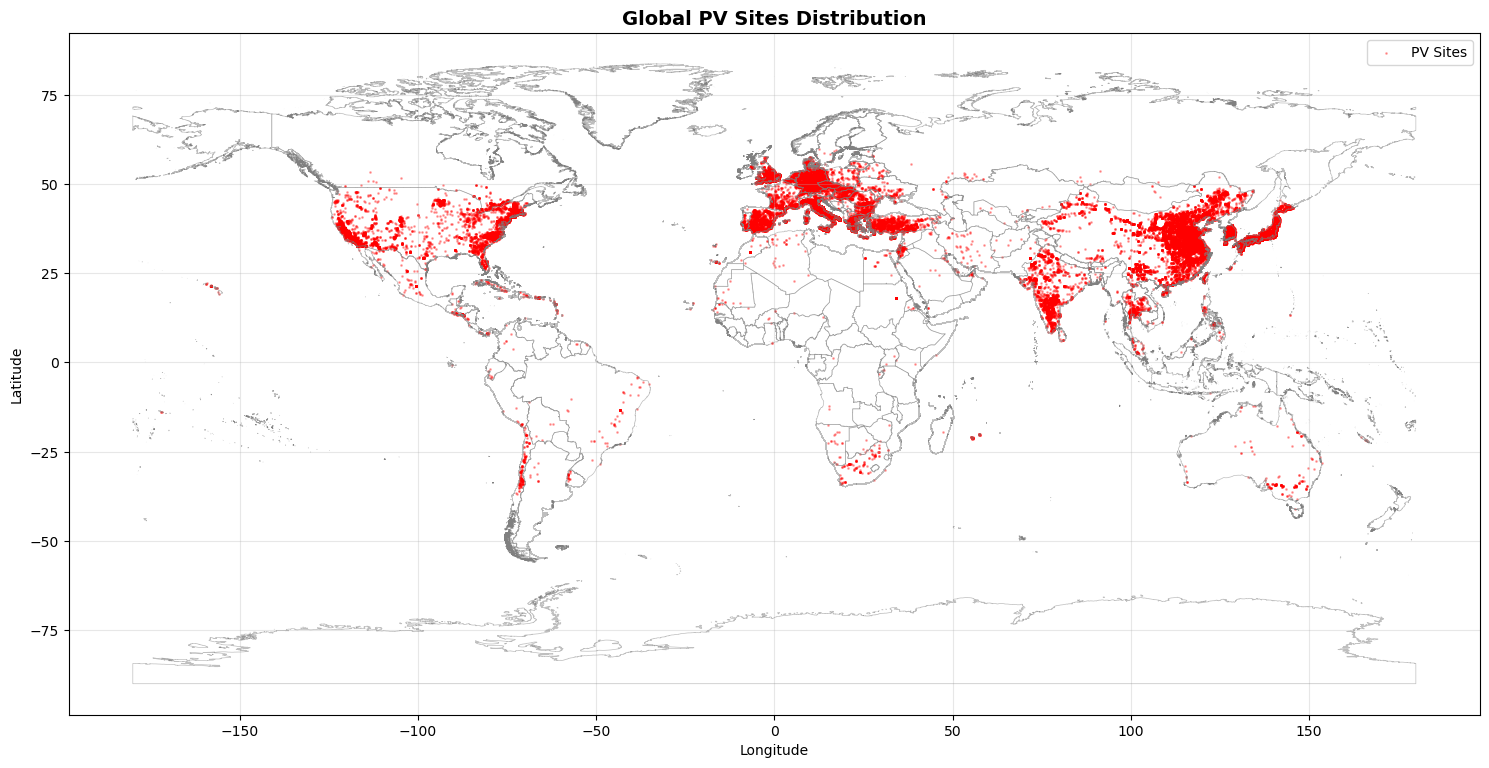


📈 Plotted 68661 PV sites


In [13]:
pv_2018=r'D:\xarray\aligned2\pv\PV_2018_for_aligning.csv'
pv_2020=r'D:\xarray\aligned2\pv\PV_2020_for_aligning.csv'

pv_2018=pd.read_csv(pv_2018,index_col=0)
pv_2020=pd.read_csv(pv_2020,index_col=0)

if pv_2018 is not None and gdf_world is not None:
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot world boundaries
    gdf_world.boundary.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5)
    
    # Plot PV sites
    ax.scatter(pv_2018.lon, pv_2018.lat, s=1, c='red', alpha=0.3, label='PV Sites')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Global PV Sites Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Plotted {len(pv_2018)} PV sites")
else:
    print("\n⚠️ Cannot plot - data not loaded")

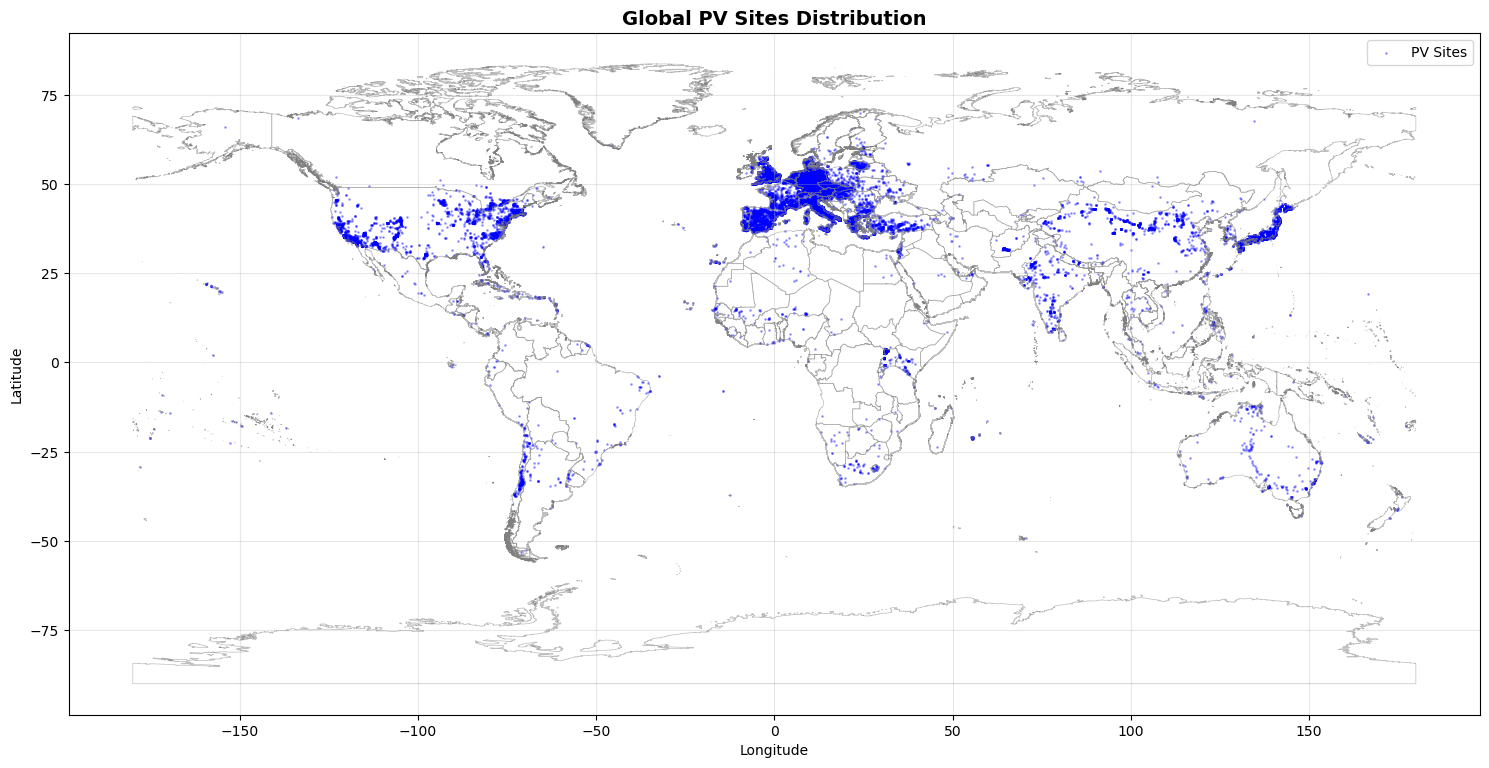


📈 Plotted 35272 PV sites


In [14]:
if pv_2020 is not None and gdf_world is not None:
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot world boundaries
    gdf_world.boundary.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5)
    
    # Plot PV sites
    ax.scatter(pv_2020.lon, pv_2020.lat, s=1, c='blue', alpha=0.3, label='PV Sites')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Global PV Sites Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Plotted {len(pv_2020)} PV sites")
else:
    print("\n⚠️ Cannot plot - data not loaded")

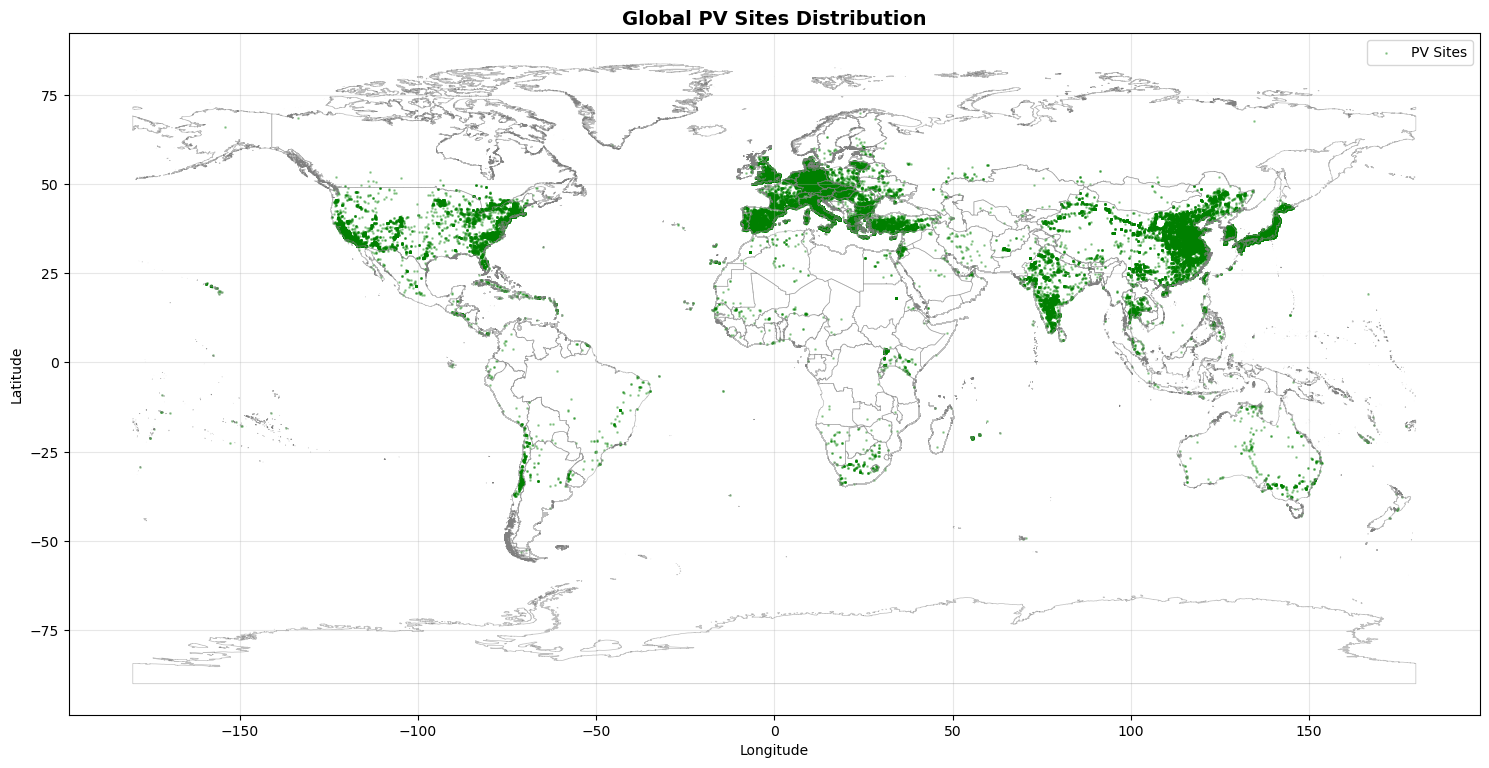


📈 Plotted 103927 PV sites


In [15]:
if df_pv is not None and gdf_world is not None:
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot world boundaries
    gdf_world.boundary.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5)
    
    # Plot PV sites
    ax.scatter(df_pv.lon, df_pv.lat, s=1, c='green', alpha=0.3, label='PV Sites')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Global PV Sites Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Plotted {len(df_pv)} PV sites")
else:
    print("\n⚠️ Cannot plot - data not loaded")

## 9. Feature Variables Inspection

In [16]:
from landuse.data import (
    get_all_feature_variables,
    get_all_abandonment_variables,
    get_numeric_features,
    get_categorical_features
)

print("📋 Variable Definitions:\n")

print("Feature Variables:")
for var in get_all_feature_variables():
    print(f"  - {var}")

print("\nAbandonment Variables:")
for var in get_all_abandonment_variables():
    print(f"  - {var}")

print("\nNumeric Features (for ML):")
for var in get_numeric_features():
    print(f"  - {var}")

print("\nCategorical Features:")
for var in get_categorical_features():
    print(f"  - {var}")

📋 Variable Definitions:

Feature Variables:
  - DEM
  - Powerdist
  - PrimaryRoad
  - SecondaryRoad
  - TertiaryRoad
  - Slope
  - GDPpc
  - GDPtot
  - GURdist
  - Population
  - gdmp
  - rsds
  - tas
  - wind

Abandonment Variables:
  - current_abandonment
  - recultivation
  - abandonment_duration
  - abandonment_year

Numeric Features (for ML):
  - lat
  - lon
  - GDPpc
  - GDPtot
  - GURdist
  - DEM
  - Slope
  - Population
  - Powerdist
  - PrimaryRoad
  - SecondaryRoad
  - TertiaryRoad
  - gdmp
  - rsds
  - tas
  - wind

Categorical Features:
  - landcover


## 10. Test Summary

In [20]:
print("\n" + "="*60)
print("📊 TEST SUMMARY")
print("="*60)

tests = [
    ("Configuration", config is not None),
    ("Global Paths", paths is not None),
    ("Abandonment Dataset", ds is not None),
    ("Abandonment CSV", df_abandon is not None),
    ("PV Sites", df_pv is not None),
    ("World Boundaries", gdf_world is not None),
]

for test_name, result in tests:
    status = "✅ PASS" if result else "❌ FAIL"
    print(f"  {test_name:.<40} {status}")

passed = sum(1 for _, r in tests if r)
total = len(tests)

print("\n" + "="*60)
print(f"Results: {passed}/{total} tests passed ({passed/total*100:.1f}%)")
print("="*60)


📊 TEST SUMMARY
  Configuration........................... ✅ PASS
  Global Paths............................ ✅ PASS
  Abandonment Dataset..................... ❌ FAIL
  Abandonment CSV......................... ✅ PASS
  PV Sites................................ ✅ PASS
  World Boundaries........................ ✅ PASS

Results: 5/6 tests passed (83.3%)


# New pv data

这里需要注意的point，第一：微软数据是否带有时间戳；第二，将坐标的数据精度统一

In [10]:
from landuse.data import GlobalDataPaths, get_global_paths

# Load config
config_path = Path.cwd().parent / "configs" / "global.yaml"
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Initialize paths
paths = GlobalDataPaths(config, workspace_root=Path.cwd().parent)

print("📂 Global Data Paths Initialized")
print(f"   Workspace: {paths.workspace_root}")
print(f"   Total paths: {len(paths.list_all_paths())}")

📂 Global Data Paths Initialized
   Workspace: c:\Dev\Landuse_Global_Pipeline_Worktree
   Total paths: 27


float64
EPSG:3857
PV CRS: EPSG:3857
PV bounds: [-19517602.78293351  -5746206.15099073  19813051.00648427
  10950937.17101752]
World CRS: EPSG:4326
World bounds: [-180.        -90.        180.         83.658333]


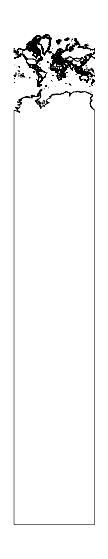

In [45]:
# 从 config 中获取 data 部分的 paths，然后取得 pv_embedding 路径
import pandas as pd
import geopandas as gpd

pv_data_paths = config.get("data", {}).get("paths", {}).get("pv_embedding",{})
dfc_pv_embedding = pd.read_csv(pv_data_paths)
print(dfc_pv_embedding['lon'].dtype)

gdf_world_path = config.get("data", {}).get("paths", {}).get("world_shp", None)
gdf_world = gpd.read_file(gdf_world_path) if gdf_world_path else None

world_pv = "..\world_shp\solar_all_2024q2_v1.gpkg"
world_pv = gpd.read_file(world_pv)
print(world_pv.crs)

print("PV CRS:", world_pv.crs)
print("PV bounds:", world_pv.total_bounds)

print("World CRS:", gdf_world.crs)
print("World bounds:", gdf_world.total_bounds)

world_3857 = gdf_world.to_crs("EPSG:3857")

fig, ax = plt.subplots(figsize=(14, 7))
world_3857.boundary.plot(ax=ax, linewidth=0.4, color="black")
world_pv.plot(ax=ax, color="red", alpha=0.3, linewidth=0)
ax.set_axis_off()
plt.show()


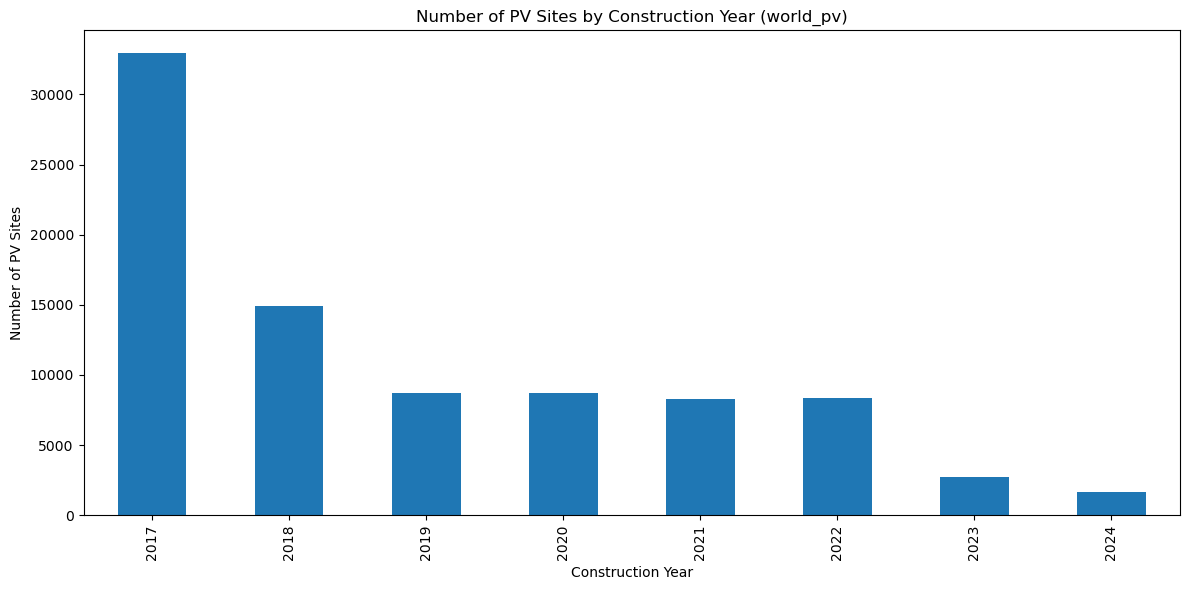

In [ ]:
import matplotlib.pyplot as plt

# Count the number of sites constructed each year
year_counts = world_pv['construction_year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')
plt.xlabel('Construction Year')
plt.ylabel('Number of PV Sites')
plt.title('Number of PV Sites by Construction Year (world_pv)')
plt.tight_layout()
plt.show()

C:\Users\zpy10\AppData\Local\Temp\ipykernel_57876\1619337380.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pv_pts["geometry"] = pv_pts.geometry.centroid


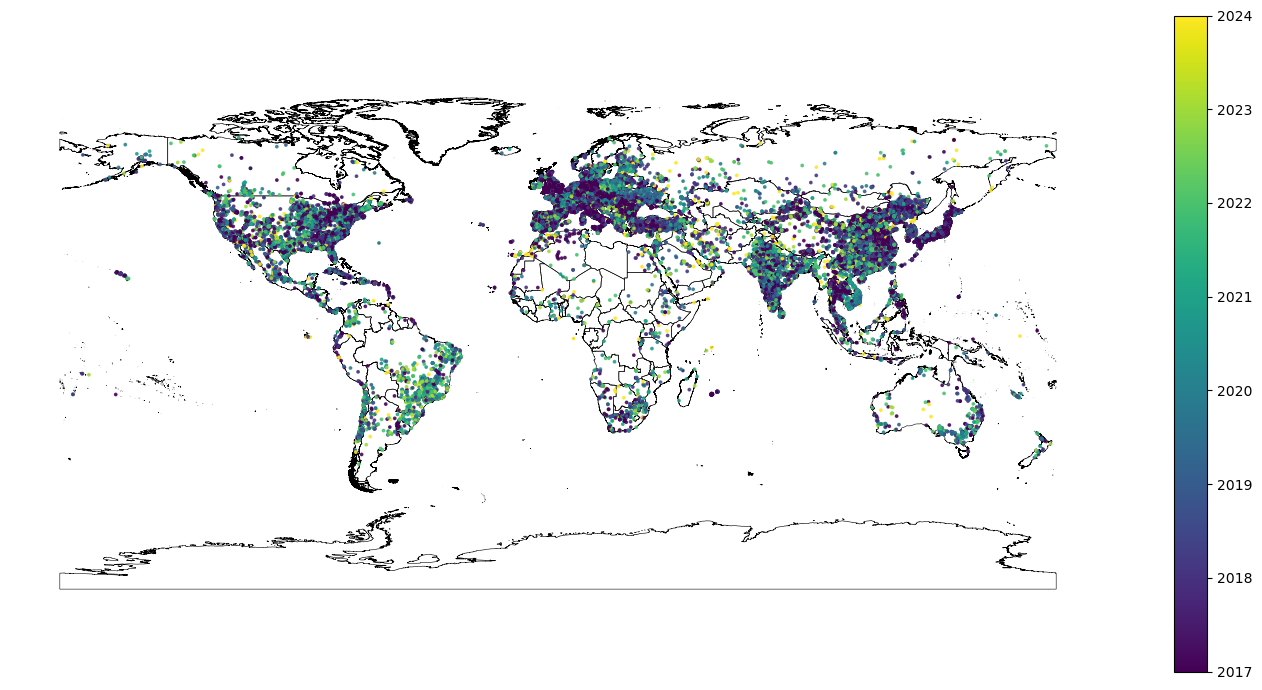

In [47]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 统一 CRS
pv = world_pv.to_crs("EPSG:4326")
world = gdf_world.to_crs("EPSG:4326")

# 用质心当点（可视化用足够了）
pv_pts = pv.copy()
pv_pts["geometry"] = pv_pts.geometry.centroid

fig, ax = plt.subplots(figsize=(14, 7))
world.boundary.plot(ax=ax, color="black", linewidth=0.4, zorder=1)

pv_pts.plot(
    ax=ax,
    column="construction_year",
    cmap="viridis",
    legend=True,
    markersize=3,     # 👈 关键：调大就看得见
    alpha=0.8,
    zorder=2
)

ax.set_axis_off()
plt.tight_layout()
plt.show()
